In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.models.signature import infer_signature
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    log_loss, f1_score, precision_score, recall_score, 
    accuracy_score, confusion_matrix, classification_report
)

In [2]:
df = pd.read_csv('data/customer_churn_0.csv')

In [3]:
df.dtypes

Call  Failure                int64
Complains                    int64
Subscription  Length         int64
Charge  Amount               int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object

In [4]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
df.shape

(1050, 14)

In [6]:
df.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

In [7]:
df.duplicated().sum()

np.int64(87)

In [8]:
def plot_numerical_variables(df, drop_columns=None):
    numerical_cols = df.select_dtypes(include=['float', 'int']).columns

    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for idx, col in enumerate(numerical_cols):
        sns.histplot(data=df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].tick_params(axis='x', rotation=45)
    # Hide any unused subplots
    for ax in axes[len(numerical_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

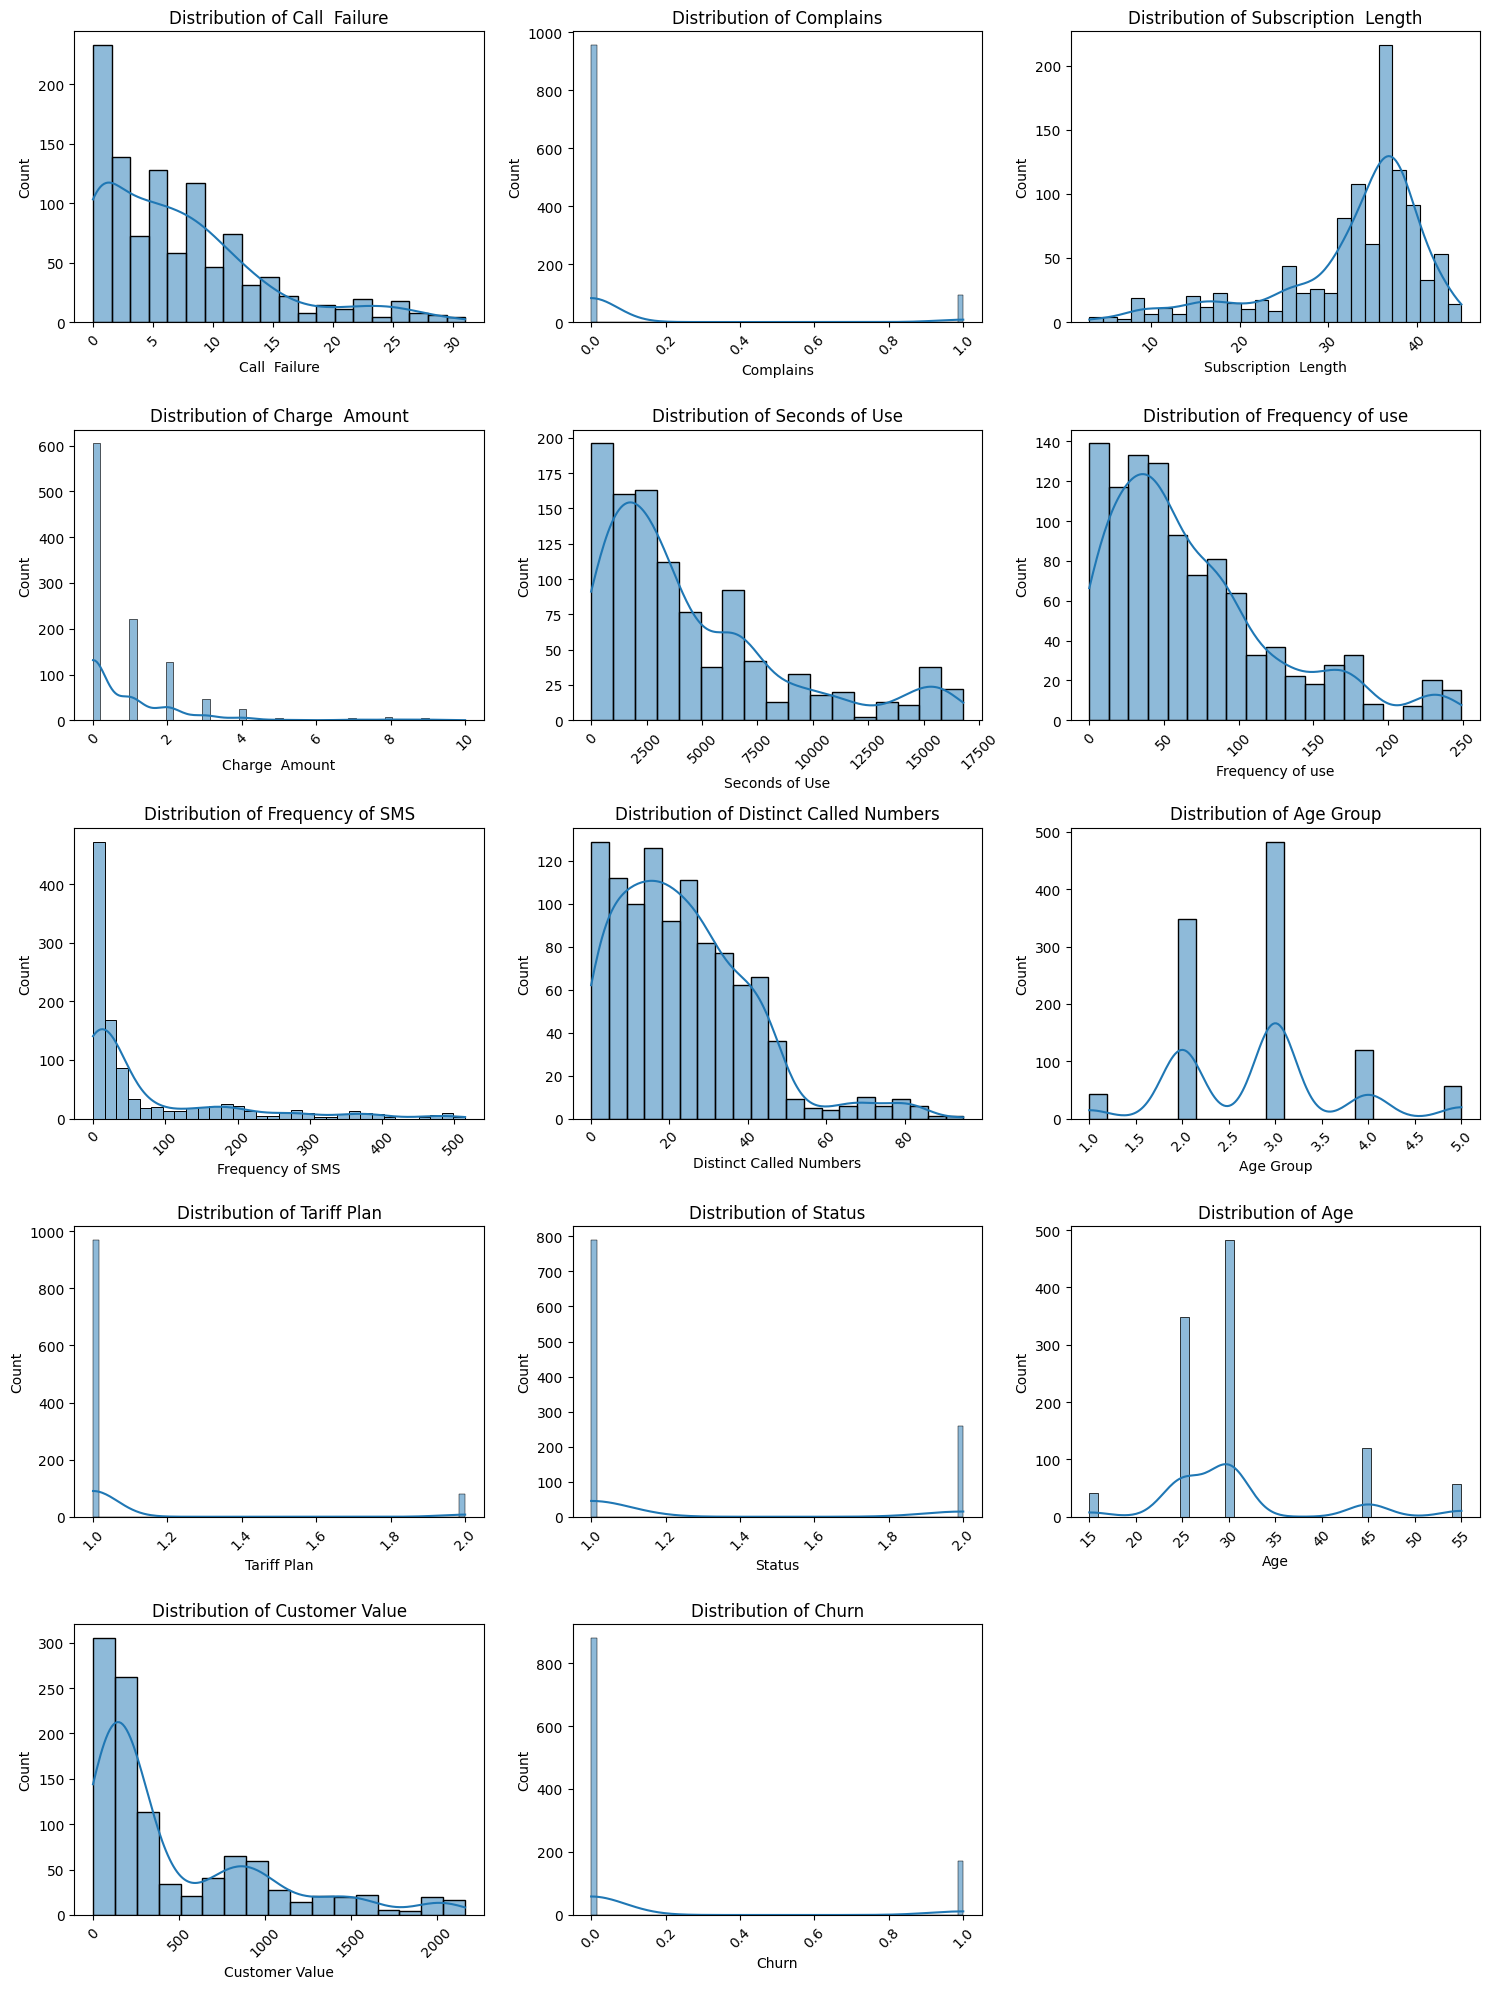

In [9]:
plot_numerical_variables(df)

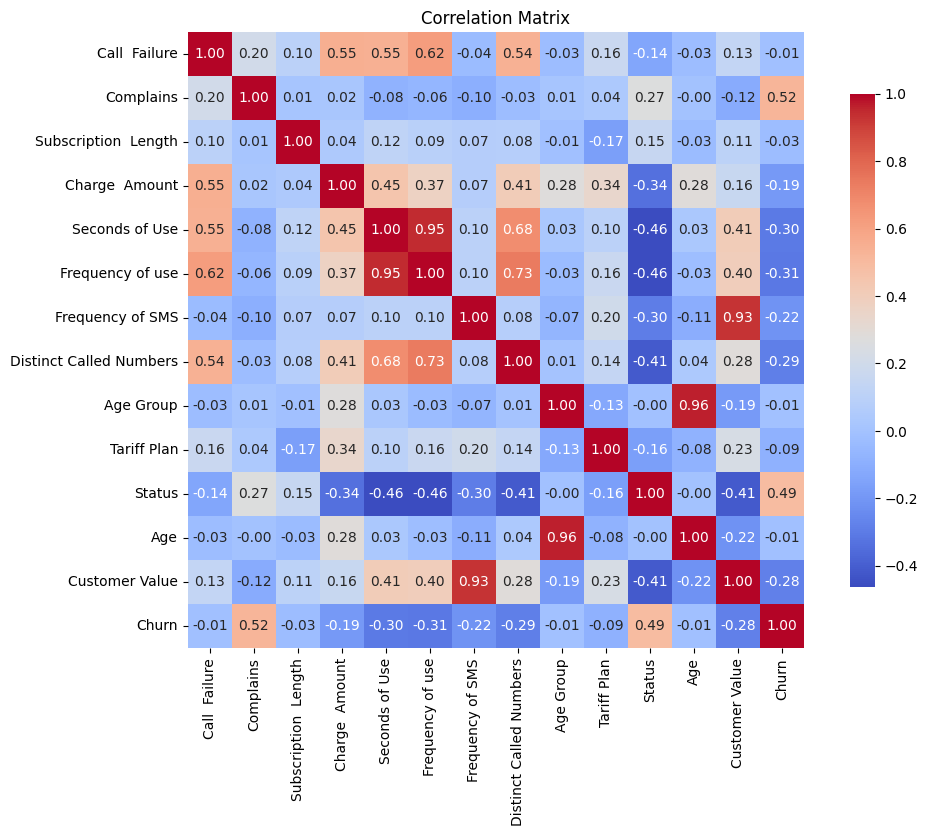

In [10]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [ ]:
mlflow.set_tracking_uri("http://18.224.82.30:5000/")
mlflow.set_experiment("mlops-churn-pipeline")

<Experiment: artifact_location='s3://mlops-churn-pipeline/mlflow/1', creation_time=1752288420889, experiment_id='1', last_update_time=1752288420889, lifecycle_stage='active', name='mlops-churn-pipeline', tags={}>

In [12]:
def prepare_data(df):
    X = df.copy()
    y = X.pop('Churn')
    
    X = X[['Complains']].copy()

    return X, y

In [13]:
X, y = prepare_data(df)

In [14]:
X.shape, y.shape

((1050, 1), (1050,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((840, 1), (210, 1), (840,), (210,))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       711
           1       0.78      0.46      0.58       129

    accuracy                           0.90       840
   macro avg       0.84      0.72      0.76       840
weighted avg       0.89      0.90      0.88       840

Confusion Matrix:


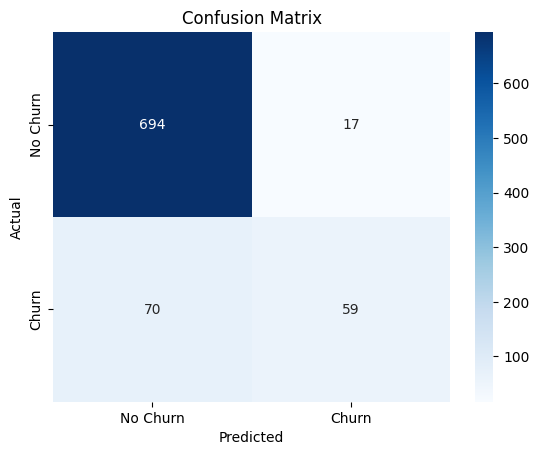

/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/07/11 19:59:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/s

🏃 View run angry-mare-109 at: http://18.224.82.30:5000/#/experiments/1/runs/5485de73348b477a85d6258579b97f9c
🧪 View experiment at: http://18.224.82.30:5000/#/experiments/1


ModuleNotFoundError: No module named 'boto3'

In [17]:

with mlflow.start_run():
    mlflow.set_tag("dataset", "X_train")

    for idx, col in enumerate(X.columns):
        mlflow.log_param(f"feature_{idx}", col)

    params = {
        "n_estimators": 100,
        "max_depth": 3,
        "learning_rate": 0.1,
        "random_state": 42
    }
    mlflow.log_params(params)

    clf = XGBClassifier(**params, objective='binary:logistic', eval_metric='logloss')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_train) # Predict on training data to eval bias first
    y_pred_proba = clf.predict_proba(X_train)

    mlflow.log_metric("log_loss", log_loss(y_train, y_pred_proba))
    mlflow.log_metric("f1_score", f1_score(y_train, y_pred))
    mlflow.log_metric("precision_score", precision_score(y_train, y_pred))
    mlflow.log_metric("recall_score", recall_score(y_train, y_pred))
    mlflow.log_metric("accuracy_score", accuracy_score(y_train, y_pred))
    
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    model_signature = infer_signature(X_train, y_pred)
    mlflow.xgboost.log_model(clf, artifact_path="model",
        registered_model_name="XGBoostChurnModel",
        signature=model_signature,
        input_example=X_train.head(1))

    
    